In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import mne
import glob
from mne.preprocessing import ICA
import pandas as pd

%matplotlib notebook

In [16]:
run = 3
subject_id = 'S17'
alpha_dir = '/Users/nicolaspiron/Documents/PULSATION/Data/EEG/Alpheye/'
files = glob.glob(alpha_dir + subject_id +'*')
#sorting files because they are sometime in the wrong order somehow
files.sort()
raw = mne.io.read_raw_bdf(files[run-1])
raw.load_data()
raw.plot(scalings='auto');
raw.info

Extracting EDF parameters from /Users/nicolaspiron/Documents/PULSATION/Data/EEG/Alpheye/S17_Alpheye_r3.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 316415  =      0.000 ...   308.999 secs...
Using pyopengl with version 3.1.6


<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 72 EEG, 1 Stimulus
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 208.0 Hz
 meas_date: 2023-04-20 11:26:59 UTC
 nchan: 73
 projs: []
 sfreq: 1024.0 Hz
>

Channels marked as bad:
['FT7', 'F7', 'F1', 'AF7', 'PO3', 'CP4']


In [17]:
raw.drop_channels(['EXG7','EXG8'])
raw.set_channel_types({'EXG1': 'eog', 'EXG2': 'eog','EXG3': 'eog','EXG4': 'eog', 'EXG5': 'eog','EXG6': 'eog'})
raw.set_montage('biosemi64') 

raw.resample(500)
raw.filter(1.,30., phase='zero-double')

#bad_channels = ['C4', 'Iz']
#raw.info['bads'] = bad_channels
mne.io.Raw.interpolate_bads(raw, reset_bads=True)
raw.plot()

Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
90 events found
Event IDs: [  2   4  10 128]
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
90 events found
Event IDs: [  2   4  10 128]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-12 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (3.302

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Interpolating bad channels
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 58 sensor positions
Interpolating 6 sensors


[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.3s finished


Using pyopengl with version 3.1.6


Channels marked as bad:
none


Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 24 components
 
Fitting ICA took 2.7s.


<IPython.core.display.Javascript object>


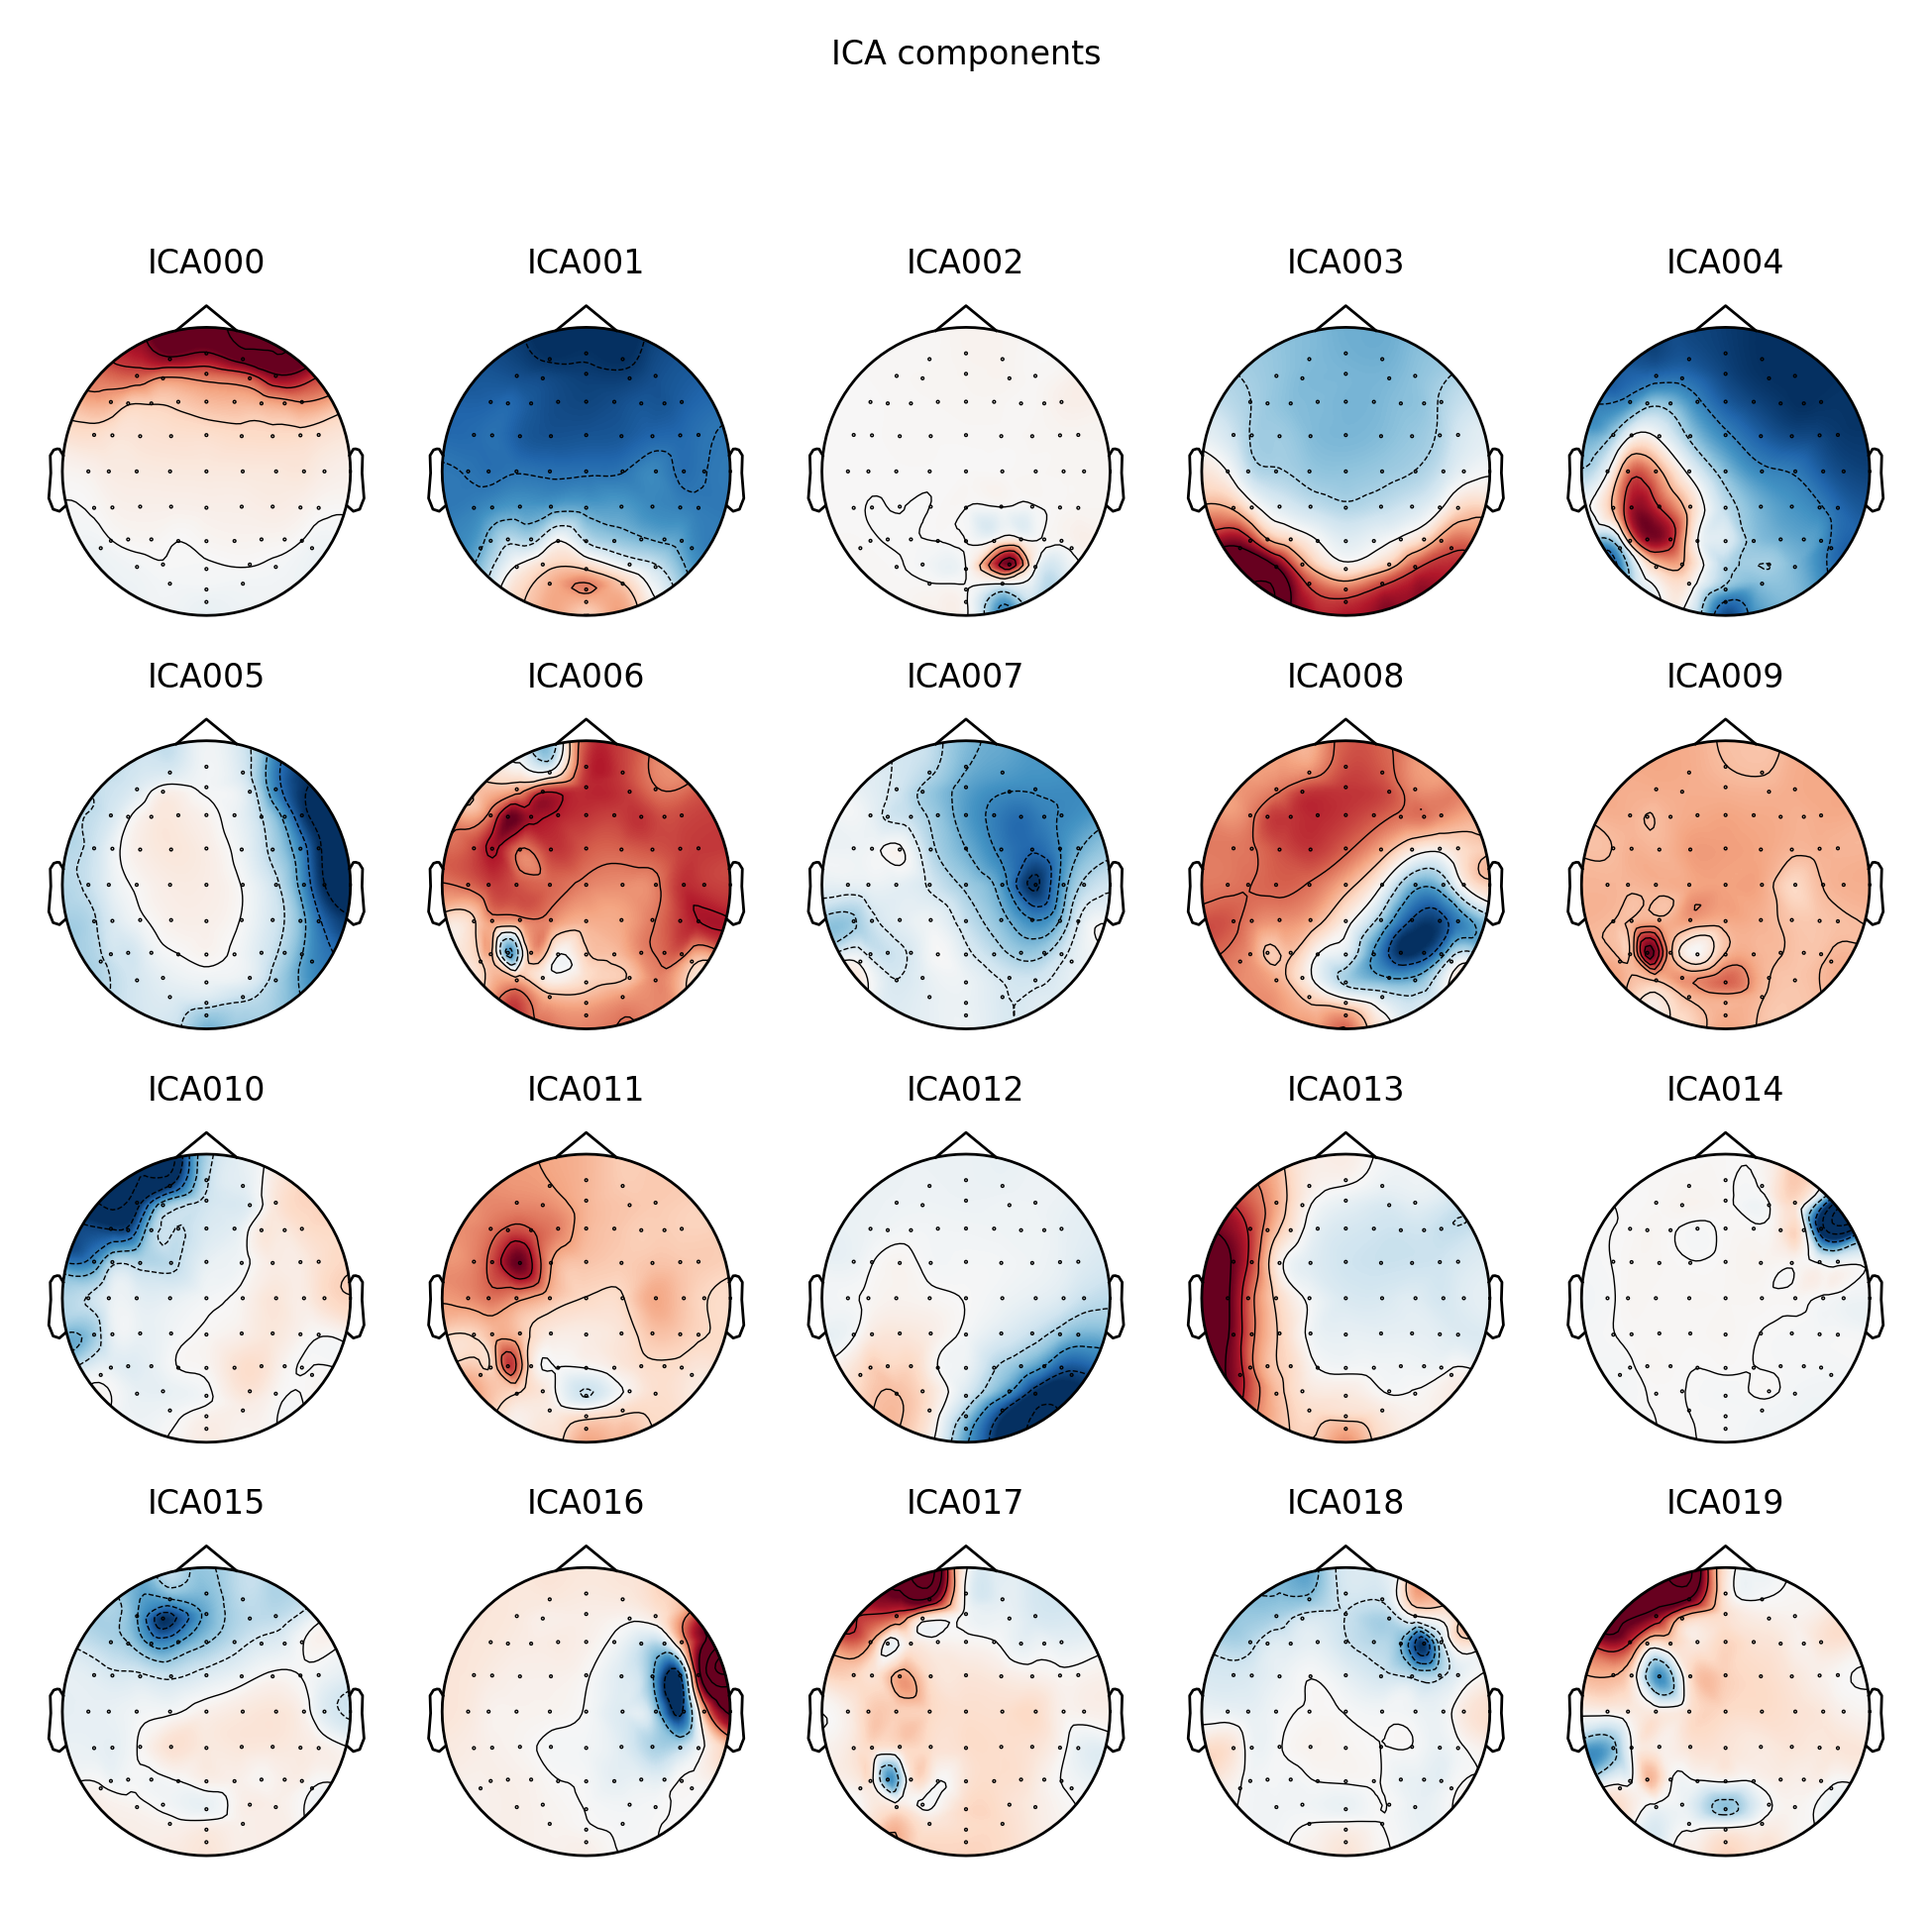

<IPython.core.display.Javascript object>


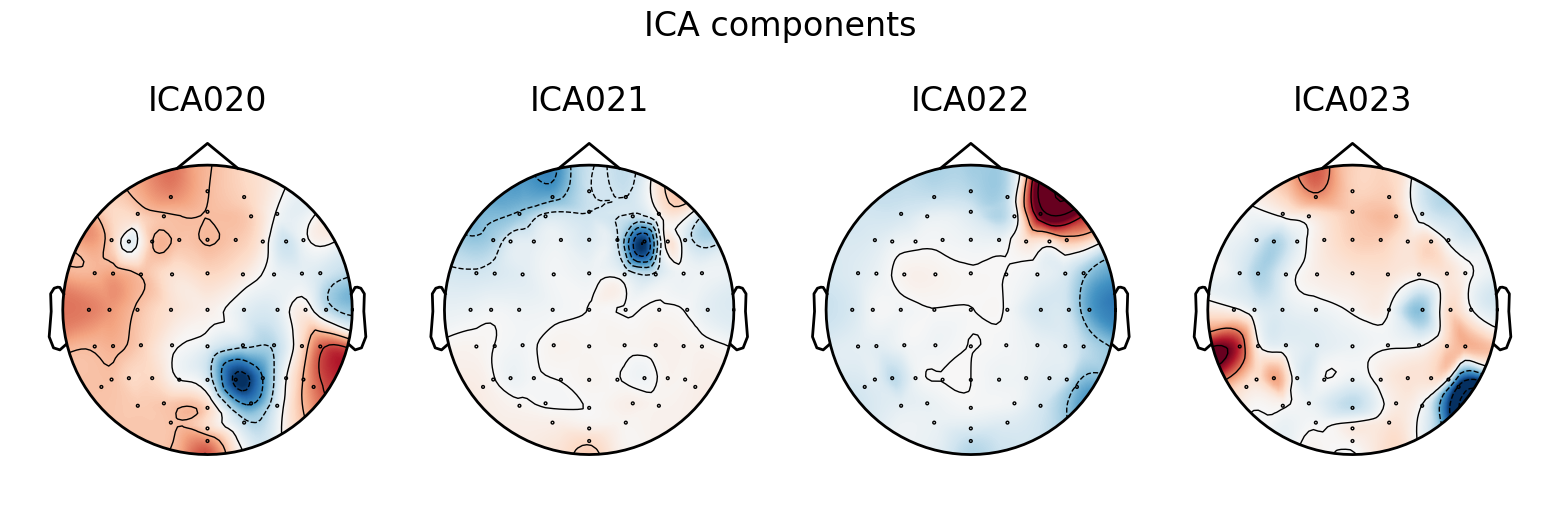

[<MNEFigure size 975x967 with 20 Axes>, <MNEFigure size 780x260.5 with 4 Axes>]

In [18]:
ica = ICA(n_components=24, method='infomax', random_state=42)
ica.fit(raw, decim=10)
ica.plot_components()

In [ ]:
ica.plot_sources(raw)

In [19]:
ica.exclude = [0]
raw_ica= ica.apply(raw)

Applying ICA to Raw instance
    Transforming to ICA space (24 components)
    Zeroing out 1 ICA component
    Projecting back using 64 PCA components


In [20]:
e_list = mne.find_events(raw_ica, stim_channel='Status')
df = pd.DataFrame(e_list, columns=['timepoint', 'duration', 'stim'])
df_stim = df[(df['stim'] == 2) | (df['stim'] == 4)].reset_index()
df_stim = df_stim.add_prefix('img_')

mne_events = df_stim[['img_timepoint', 'img_duration', 'img_stim']].values
event_dict = {'Landscape':2,
             'Human':4}

epochs = mne.Epochs(raw_ica, mne_events, event_id=event_dict, tmin=-0.2, tmax=6, baseline=(-0.2, 0), event_repeated='drop', preload=True)
epochs.set_eeg_reference(ref_channels='average');
epochs.plot()

Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
90 events found
Event IDs: [  2   4  10 128]
Not setting metadata
30 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 3101 original time points ...
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Using pyopengl with version 3.1.6


Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


In [21]:
out_dir = '/Users/nicolaspiron/Documents/PULSATION/Python_MNE/preproc/Alpheye_out/data/'
ICA_filename = subject_id+'_r'+str(run)+'_ICA.fif'
raw_filename = subject_id+'_r'+str(run)+'_raw.fif'
raw_ICA_filename = subject_id+'_r'+str(run)+'_rawICA.fif'
epochs_filename = subject_id+'_r'+str(run)+'_epochs.fif'

ica.save(os.path.join(out_dir, 'ica', ICA_filename), overwrite=True)
raw.save(os.path.join(out_dir, raw_filename), overwrite=True)
raw_ica.save(os.path.join(out_dir, 'raw_ica', raw_ICA_filename), overwrite=True)
epochs.save(os.path.join(out_dir, 'epochs', epochs_filename), overwrite=True)

Writing ICA solution to /Users/nicolaspiron/Documents/PULSATION/Python_MNE/preproc/Alpheye_out/data/ica/S17_r3_ICA.fif...
Writing /Users/nicolaspiron/Documents/PULSATION/Python_MNE/preproc/Alpheye_out/data/S17_r3_raw.fif


/var/folders/4f/_jg1y72j6_ggv65n730flb280000gn/T/ipykernel_57125/1210582442.py:7: RuntimeWarning: This filename (/Users/nicolaspiron/Documents/PULSATION/Python_MNE/preproc/Alpheye_out/data/ica/S17_r3_ICA.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save(os.path.join(out_dir, 'ica', ICA_filename), overwrite=True)


Closing /Users/nicolaspiron/Documents/PULSATION/Python_MNE/preproc/Alpheye_out/data/S17_r3_raw.fif
[done]
Writing /Users/nicolaspiron/Documents/PULSATION/Python_MNE/preproc/Alpheye_out/data/raw_ica/S17_r3_rawICA.fif
Closing /Users/nicolaspiron/Documents/PULSATION/Python_MNE/preproc/Alpheye_out/data/raw_ica/S17_r3_rawICA.fif
[done]
Overwriting existing file.


/var/folders/4f/_jg1y72j6_ggv65n730flb280000gn/T/ipykernel_57125/1210582442.py:9: RuntimeWarning: This filename (/Users/nicolaspiron/Documents/PULSATION/Python_MNE/preproc/Alpheye_out/data/raw_ica/S17_r3_rawICA.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_ica.save(os.path.join(out_dir, 'raw_ica', raw_ICA_filename), overwrite=True)
/var/folders/4f/_jg1y72j6_ggv65n730flb280000gn/T/ipykernel_57125/1210582442.py:10: RuntimeWarning: This filename (/Users/nicolaspiron/Documents/PULSATION/Python_MNE/preproc/Alpheye_out/data/epochs/S17_r3_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(os.path.join(out_dir, 'epochs', epochs_filename), overwrite=True)


In [22]:
path_epochs = '/Users/nicolaspiron/Documents/PULSATION/Python_MNE/preproc/Alpheye_out/data/epochs/'

files = glob.glob(path_epochs+subject_id+'*')
files.sort()

e1 = mne.read_epochs(files[0])
e2 = mne.read_epochs(files[1])
e3 = mne.read_epochs(files[2])

total_epochs = mne.concatenate_epochs([e1, e2, e3])
total_epochs.save(os.path.join(path_epochs, subject_id + '_total_epochs.fif'), overwrite=True)

Reading /Users/nicolaspiron/Documents/PULSATION/Python_MNE/preproc/Alpheye_out/data/epochs/S17_r1_epochs.fif ...
    Found the data of interest:
        t =    -200.00 ...    6000.00 ms
        0 CTF compensation matrices available
Not setting metadata
29 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/nicolaspiron/Documents/PULSATION/Python_MNE/preproc/Alpheye_out/data/epochs/S17_r2_epochs.fif ...
    Found the data of interest:
        t =    -200.00 ...    6000.00 ms
        0 CTF compensation matrices available


/var/folders/4f/_jg1y72j6_ggv65n730flb280000gn/T/ipykernel_57125/80427427.py:6: RuntimeWarning: This filename (/Users/nicolaspiron/Documents/PULSATION/Python_MNE/preproc/Alpheye_out/data/epochs/S17_r1_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  e1 = mne.read_epochs(files[0])
/var/folders/4f/_jg1y72j6_ggv65n730flb280000gn/T/ipykernel_57125/80427427.py:7: RuntimeWarning: This filename (/Users/nicolaspiron/Documents/PULSATION/Python_MNE/preproc/Alpheye_out/data/epochs/S17_r2_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  e2 = mne.read_epochs(files[1])


Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/nicolaspiron/Documents/PULSATION/Python_MNE/preproc/Alpheye_out/data/epochs/S17_r3_epochs.fif ...
    Found the data of interest:
        t =    -200.00 ...    6000.00 ms
        0 CTF compensation matrices available
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
89 matching events found
Applying baseline correction (mode: mean)


/var/folders/4f/_jg1y72j6_ggv65n730flb280000gn/T/ipykernel_57125/80427427.py:8: RuntimeWarning: This filename (/Users/nicolaspiron/Documents/PULSATION/Python_MNE/preproc/Alpheye_out/data/epochs/S17_r3_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  e3 = mne.read_epochs(files[2])
/var/folders/4f/_jg1y72j6_ggv65n730flb280000gn/T/ipykernel_57125/80427427.py:11: RuntimeWarning: This filename (/Users/nicolaspiron/Documents/PULSATION/Python_MNE/preproc/Alpheye_out/data/epochs/S17_total_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  total_epochs.save(os.path.join(path_epochs, subject_id + '_total_epochs.fif'), overwrite=True)
